# Import Libraries

In [1079]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import pyplot as plt
import pandas as pd, numpy as np
from google.cloud import vision
import io
import os, cv2
from collections import Counter
import sys
import plotly.graph_objects as go

# Define boxes around the equations

In [1080]:
image="3"

img = cv2.imread("images/"+image+".JPG")

# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# invert
thresh = 255 - thresh

# apply horizontal morphology close
kernel = np.ones((100 ,10000), np.uint8)
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# get external contours
contours = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

# draw contours
result = img.copy()
for cntr in contours:
    # get bounding boxes
    pad = 100
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(result, (x-pad, y-pad), (x+w+pad, y+h+pad), (0, 0, 255), 4)

# save result
cv2.imwrite("images/"+image+"_box.jpg",result)

True

# OCR with google API

In [1081]:
#os.chdir(r"/Users/pedroleal/Desktop/Ironhack/Final project/Project/Cloudvision/HandwritingRecognition_GoogleCloudVision/images")

In [1082]:
#

#fileList = [x for x in os.listdir() if 'jpg'  in x.lower()]
#fileList[:10]
#image_use=1
filename="images/"+image+"_box.jpg"
#Image(filename=filename, width = 300)


In [1083]:
#Page segmentation

def findHorizontalLines(img):
    #img = cv2.imread(img) 
    img =result
    #convert image to greyscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # set threshold to remove background noise
    thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    
    # define rectangle structure (line) to look for: width 100, hight 1. This is a 
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (200,1))
    
    # Find horizontal lines
    lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    
    return lineLocations

lineLocations = findHorizontalLines(img)
#plt.figure(figsize=(24,24))
#plt.imshow(lineLocations, cmap='Greys')

In [1084]:
img = result 

#convert image to greyscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# set threshold to remove background noise
thresh = cv2.threshold(gray,30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]


# define rectangle structure (line) to look for: width 100, hight 1. This is a 
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (500,1))

# Find horizontal lines
lineLocations = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    


#lineLocations = findHorizontalLines(img)
#plt.figure(figsize=(24,24))
#plt.imshow(lineLocations, cmap='Greys')

In [1085]:
df_lineLocations = pd.DataFrame(lineLocations.sum(axis=1)).reset_index()
df_lineLocations.columns = ['rowLoc', 'LineLength']
df_lineLocations[df_lineLocations['LineLength'] > 50]

df_lineLocations['line'] = 0
df_lineLocations['line'][df_lineLocations['LineLength'] > 100] = 1

df_lineLocations['cumSum'] = df_lineLocations['line'].cumsum()

<ipython-input-1085-bde6a9e0a013>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1086]:
import pandasql as ps

query = '''
select row_number() over (order by cumSum) as SegmentOrder
, min(rowLoc) as SegmentStart
, max(rowLoc) - min(rowLoc) as Height
from df_lineLocations
where line = 0
--and CumSum !=0
group by cumSum
'''

df_SegmentLocations  = ps.sqldf(query, locals())

In [1087]:
def pageSegmentation1(img, w, df_SegmentLocations):
    img = cv2.imread(img) 
    im2 = img.copy()
    segments = []

    for i in range(len(df_SegmentLocations)):
        y = df_SegmentLocations['SegmentStart'][i]
        h = df_SegmentLocations['Height'][i]

        cropped = im2[y:y + h, 0:w] 
        segments.append(cropped)
        #plt.figure(figsize=(8,8))
        #plt.imshow(cropped)
        #plt.title(str(i+1))        

    return segments

img = filename
w = lineLocations.shape[1]
segments = pageSegmentation1(img, w, df_SegmentLocations)

In [1088]:
new_segments=[]

for element in segments:
    if len(np.unique(element))>150:
        new_segments.append(element)

segments=new_segments    

In [1089]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/pedroleal/Desktop/Ironhack/Final project/Project/Cloudvision/HandwritingRecognition_GoogleCloudVision/my-key.json"
print('Credendtials from environ: {}'.format(os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')))

Credendtials from environ: /Users/pedroleal/Desktop/Ironhack/Final project/Project/Cloudvision/HandwritingRecognition_GoogleCloudVision/my-key.json


In [1090]:
def CloudVisionTextExtractor(handwritings):
    # convert image from numpy to bytes for submittion to Google Cloud Vision
    _, encoded_image = cv2.imencode('.png', handwritings)
    content = encoded_image.tobytes()
    #image = vision.types.Image(content=content)
    image = vision.Image(content=content)
    
    # feed handwriting image segment to the Google Cloud Vision API
    client = vision.ImageAnnotatorClient()
    response = client.document_text_detection(image=image)
    
    return response

def getTextFromVisionResponse(response):
    texts = []
    for page in response.full_text_annotation.pages:
        for i, block in enumerate(page.blocks):  
            for paragraph in block.paragraphs:       
                for word in paragraph.words:
                    word_text = ''.join([symbol.text for symbol in word.symbols])
                    texts.append(word_text)

    return ' '.join(texts)

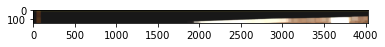

In [1091]:
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0].replace(" ","")

final_equations=[]


for j in range(0,len(segments)):
    
    first_element=[]
    second_element=[]
    third_element=[]

    for i in range(1,11):

        kernel = np.ones((5, 5), np.uint8)
        img_dilation = cv2.dilate(cv2.bitwise_not(segments[j]), kernel, iterations=i)
        handwritings=cv2.bitwise_not(img_dilation)
        response = CloudVisionTextExtractor(handwritings)
        handwrittenText = getTextFromVisionResponse(response)
        if len(handwrittenText.split("+"))==1:
            first_element.append(handwrittenText.split("+")[0].strip().lower())
            a="first"
        elif len(handwrittenText.split("+"))==2:
            first_element.append(handwrittenText.split("+")[0].strip().lower())
            second_element.append(handwrittenText.split("+")[1].strip().lower())
            a="second"
        elif len(handwrittenText.split("+"))==3:
            first_element.append(handwrittenText.split("+")[0].strip().lower())
            second_element.append(handwrittenText.split("+")[1].strip().lower())
            third_element.append(handwrittenText.split("+")[2].strip().lower())
            a="third"

        else: "Program only works until functios with 3 variables"

    if a=="first":
        final_equations.append(most_frequent(first_element))
    elif a=="second":
        final_equations.append(most_frequent(first_element)+"+"+most_frequent(second_element))
    else: final_equations.append(most_frequent(first_element)+"+"+most_frequent(second_element)+"+"+most_frequent(third_element))

plt.imshow(img_dilation)



In [1092]:
while "" in final_equations:
    final_equations.remove("")
    
final_equations

['35x+23y+40z=25', '5x+20y+42=50', '30x+15y+10z=80']

In [1093]:
numbers=[]
coefs=[[]]*len(final_equations)

import re

for i in range(0,len(final_equations)):
    el=final_equations[i].split("=")
    if el[0]==el[0].split("+"):
        numbers.append(re.findall(r'\d+', el[0])[0])
        a=el[1].split("+")
        a=" ".join(a)
        coefs[i]=re.findall(r'\d+', a)
        numbers[i]=re.findall(r'\d+', numbers[i])
        

    else:
        numbers.append(re.findall(r'\d+', el[1])[0])
        a=el[0].split("+")
        a=" ".join(a)
        coefs[i]=re.findall(r'\d+', a)
        
        

In [1094]:
if len(coefs)>len(numbers):
    sys.exit("System underdeterminated. You have more unknowns than equations. You must have the same number.")

if len(numbers)>len(coefs):
    sys.exit("System overdeterminated. You have more equations than unknowns. You must have the same number.")

In [1095]:

for i in range(0,len(numbers)):
    numbers[i]=int(numbers[i])


for i in range(0,len(coefs)):
    for j in range(0,len(coefs)):
        coefs[i][j]=int(coefs[i][j])



In [1096]:
A = np.array(coefs)
b = np.array(numbers)
x = np.linalg.solve(A, b)

In [1097]:
if len(x)==1:
    print("The solution for the system of equations presented is: \n x= {:.2f}".format(x[0]))
if len(x)==2:
    print("The solution for the system of equations presented is: \n x= {:.2f} \n y= {:.2f}".format(x[0],x[1]))
if len(x)==3:
    print("The solution for the system of equations presented is: \n x= {:.2f} \n y= {:.2f} \n z= {:.2f}".format(x[0],x[1],x[2]))

The solution for the system of equations presented is: 
 x= -2.56 
 y= 13.85 
 z= -5.10


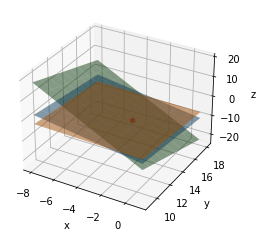

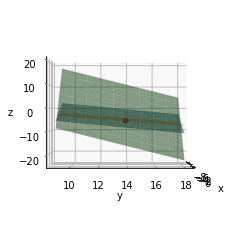

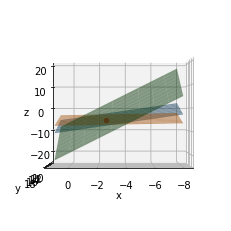

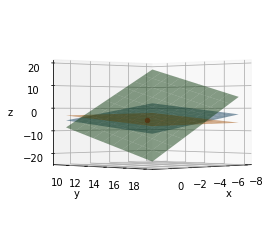

In [1098]:

if len(x)==3:
    # create the figure
    fig = plt.figure()

    a=5

    xx, yy = np.meshgrid(range(round(x[0])-a,round(x[0])+a), range(round(x[1])-a,round(x[1])+a))

    # add axes
    ax = fig.add_subplot(111,projection='3d')

    z = (numbers[0]- xx*coefs[0][0] - yy*coefs[0][1]) / coefs[0][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    z = (numbers[1]- xx*coefs[1][0] - yy*coefs[1][1]) / coefs[1][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    z = (numbers[2]- xx*coefs[2][0] - yy*coefs[2][1]) / coefs[2][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    ax.scatter3D(x[0], x[1], x[2],c="r")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    plt.show()


    # create the figure
    fig = plt.figure()

    a=5

    xx, yy = np.meshgrid(range(round(x[0])-a,round(x[0])+a), range(round(x[1])-a,round(x[1])+a))

    # add axes
    ax = fig.add_subplot(111,projection='3d')

    z = (numbers[0]- xx*coefs[0][0] - yy*coefs[0][1]) / coefs[0][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    z = (numbers[1]- xx*coefs[1][0] - yy*coefs[1][1]) / coefs[1][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    z = (numbers[2]- xx*coefs[2][0] - yy*coefs[2][1]) / coefs[2][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    ax.scatter3D(x[0], x[1], x[2],c="r")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.view_init(0, 0)
    plt.show()

    # create the figure
    fig = plt.figure()

    a=5

    xx, yy = np.meshgrid(range(round(x[0])-a,round(x[0])+a), range(round(x[1])-a,round(x[1])+a))

    # add axes
    ax = fig.add_subplot(111,projection='3d')

    z = (numbers[0]- xx*coefs[0][0] - yy*coefs[0][1]) / coefs[0][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    z = (numbers[1]- xx*coefs[1][0] - yy*coefs[1][1]) / coefs[1][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    z = (numbers[2]- xx*coefs[2][0] - yy*coefs[2][1]) / coefs[2][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    ax.scatter3D(x[0], x[1], x[2],c="r")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.view_init(0, 90)
    plt.show()

    # create the figure
    fig = plt.figure()

    a=5

    xx, yy = np.meshgrid(range(round(x[0])-a,round(x[0])+a), range(round(x[1])-a,round(x[1])+a))

    # add axes
    ax = fig.add_subplot(111,projection='3d')

    z = (numbers[0]- xx*coefs[0][0] - yy*coefs[0][1]) / coefs[0][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    z = (numbers[1]- xx*coefs[1][0] - yy*coefs[1][1]) / coefs[1][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    z = (numbers[2]- xx*coefs[2][0] - yy*coefs[2][1]) / coefs[2][2] 

    # plot the plane
    ax.plot_surface(xx, yy, z, alpha=0.5)

    ax.scatter3D(x[0], x[1], x[2],c="r")

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.view_init(0, 45)
    plt.show()

if len(x)==2:

    a=5
    xx=np.arange(x[0]-a,x[0]+a)
    yy=(numbers[0]-coefs[0][0]*xx)/coefs[0][1]
    plt.plot(xx,yy)

    xx=np.arange(x[1]-a,x[1]+a)
    yy=(numbers[1]-coefs[1][0]*xx)/coefs[1][1]
    plt.plot(xx,yy)

    plt.scatter(x[0],x[1],c="r")

    plt.show()


if len(x)==1:

    
    y=np.arange(x[0]-5,x[0]+5)
    x=np.ones(len(y))*x[0]

    plt.plot(x,y)
    plt.show()

In [1117]:
a=5
xx= np.arange(round(x[0])-a,round(x[0])+a)
yy = np.arange(round(x[0])-a,round(x[0])+a)

z = (numbers[0]- xx*coefs[0][0] - yy*coefs[0][1]) / coefs[0][2] 




In [1149]:

import plotly.graph_objects as go
import numpy as np


plane = go.Surface(x=xx, y=yy, z=np.array([z] * len(x1)))

figure = go.Figure()
figure.add_traces([plane])
figure.show()